In [7]:
import numpy as np  
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
import os

file_names = os.listdir('./data/img_align_celeba')
img_paths = ['./data/img_align_celeba/' + file_name for file_name in file_names]
len(img_paths)

70560

In [9]:
import matplotlib.pyplot as plt

def show_images(file_names, num_samples=4, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15, 15))
    for i, img_path in enumerate(file_names):
        if i == num_samples:
            break
        img = Image.open(img_path)
        img_np = np.array(img)
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.imshow(img_np)


def show_three_images(batch, num_samples=4):
    """
    Hiển thị 3 ảnh (gt_image, cond_image, mask_image) cho từng mẫu.
    Số mẫu hiển thị = num_samples (mặc định 4).
    """
    gt_image = batch['gt_image']     # (B, C, H, W)
    cond_image = batch['cond_image']   # (B, C, H, W)
    mask_image = batch['mask_image']   # (B, C, H, W)

    # Nếu các tensor ở GPU thì chuyển về CPU
    if gt_image.is_cuda:
        gt_image = gt_image.cpu()
        cond_image = cond_image.cpu()
        mask_image = mask_image.cpu()

    # Tính số hàng = num_samples, số cột = 3
    rows, cols = num_samples, 3
    plt.figure(figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        # Lấy từng ảnh
        img_gt = gt_image[i]
        img_cond = cond_image[i]
        img_mask = mask_image[i]

        # Unnormalize mỗi ảnh: x = x*0.5 + 0.5  (do bạn Normalize(mean=0.5, std=0.5))
        img_gt = img_gt * 0.5 + 0.5
        img_cond = img_cond * 0.5 + 0.5
        img_mask = img_mask * 0.5 + 0.5

        # Chuyển (C,H,W) -> (H,W,C) để hiển thị
        np_gt = img_gt.permute(1, 2, 0).numpy()
        np_cond = img_cond.permute(1, 2, 0).numpy()
        np_mask = img_mask.permute(1, 2, 0).numpy()

        # Vẽ gt_image
        plt.subplot(rows, cols, i * cols + 1)
        plt.imshow(np_gt)
        plt.title("GT Image")
        plt.axis("off")

        # Vẽ cond_image
        plt.subplot(rows, cols, i * cols + 2)
        plt.imshow(np_cond)
        plt.title("Cond Image")
        plt.axis("off")

        # Vẽ mask_image
        plt.subplot(rows, cols, i * cols + 3)
        plt.imshow(np_mask)
        plt.title("Mask Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

## Create data loader

In [10]:
num_train, num_val = 1000, 100  # demo with small data
train_imgpaths = img_paths[: num_train]
val_imgpaths = img_paths[num_train: num_train + num_val]

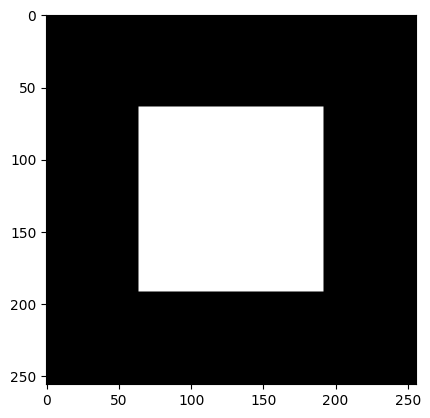

In [11]:
def bbox2mask(img_shape, bbox):
    """
    img_shape: (h, w, c)
    bbox: (x1, y1, w, h)
    """
    h_img, w_img = img_shape
    x1, y1, w, h = bbox
    mask = np.zeros((h_img, w_img), dtype=np.uint8)
    mask[y1:y1 + h, x1:x1 + w] = 1
    return mask


test_mask = bbox2mask((256, 256), (256//4, 256//4, 256//2, 256//2))
plt.imshow(test_mask, cmap='gray')

In [12]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class InpaintingDataset():
    def __init__(self, img_paths, mask_mode, data_len=100, image_size=[256, 256]):
        if data_len > 0:
            self.img_paths = img_paths[:int(data_len)]
        else:
            self.img_paths = img_paths

        self.tfs = transforms.Compose([
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])
        ])
        self.mask_mode = mask_mode
        self.image_size = image_size

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert('RGB')
        img = self.tfs(img)
        mask = self.get_mask()  # 256x256
        cond_image = img * (1. - mask) + mask * torch.randn_like(img)  # trung tâm: mask (noise)
        mask_img = img * (1. - mask) + mask       # trung tâm: 1, rìa: ảnh

        return {
            'gt_image': img,
            'cond_image': cond_image,
            'mask_image': mask_img,
            'mask': mask,
            'path': img_path
        }


    def __len__(self):
        return len(self.img_paths)

    def get_mask(self):
        if self.mask_mode == 'center':
            h, w = self.image_size
            mask = bbox2mask(self.image_size, (h//4, w//4, h//2, w//2))
        else:
            raise NotImplementedError(
                f'Mask mode {self.mask_mode} has not been implemented.')
        return torch.from_numpy(mask).unsqueeze(0)

In [13]:
from torch.utils.data import DataLoader
train_dataset = InpaintingDataset(train_imgpaths, mask_mode='center')
val_dataset = InpaintingDataset(val_imgpaths, mask_mode='center')

BATCH_SIZE = 4
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7019243..2.5860872].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7112596..3.0122087].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6763728..2.8112333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6610148..2.792546].


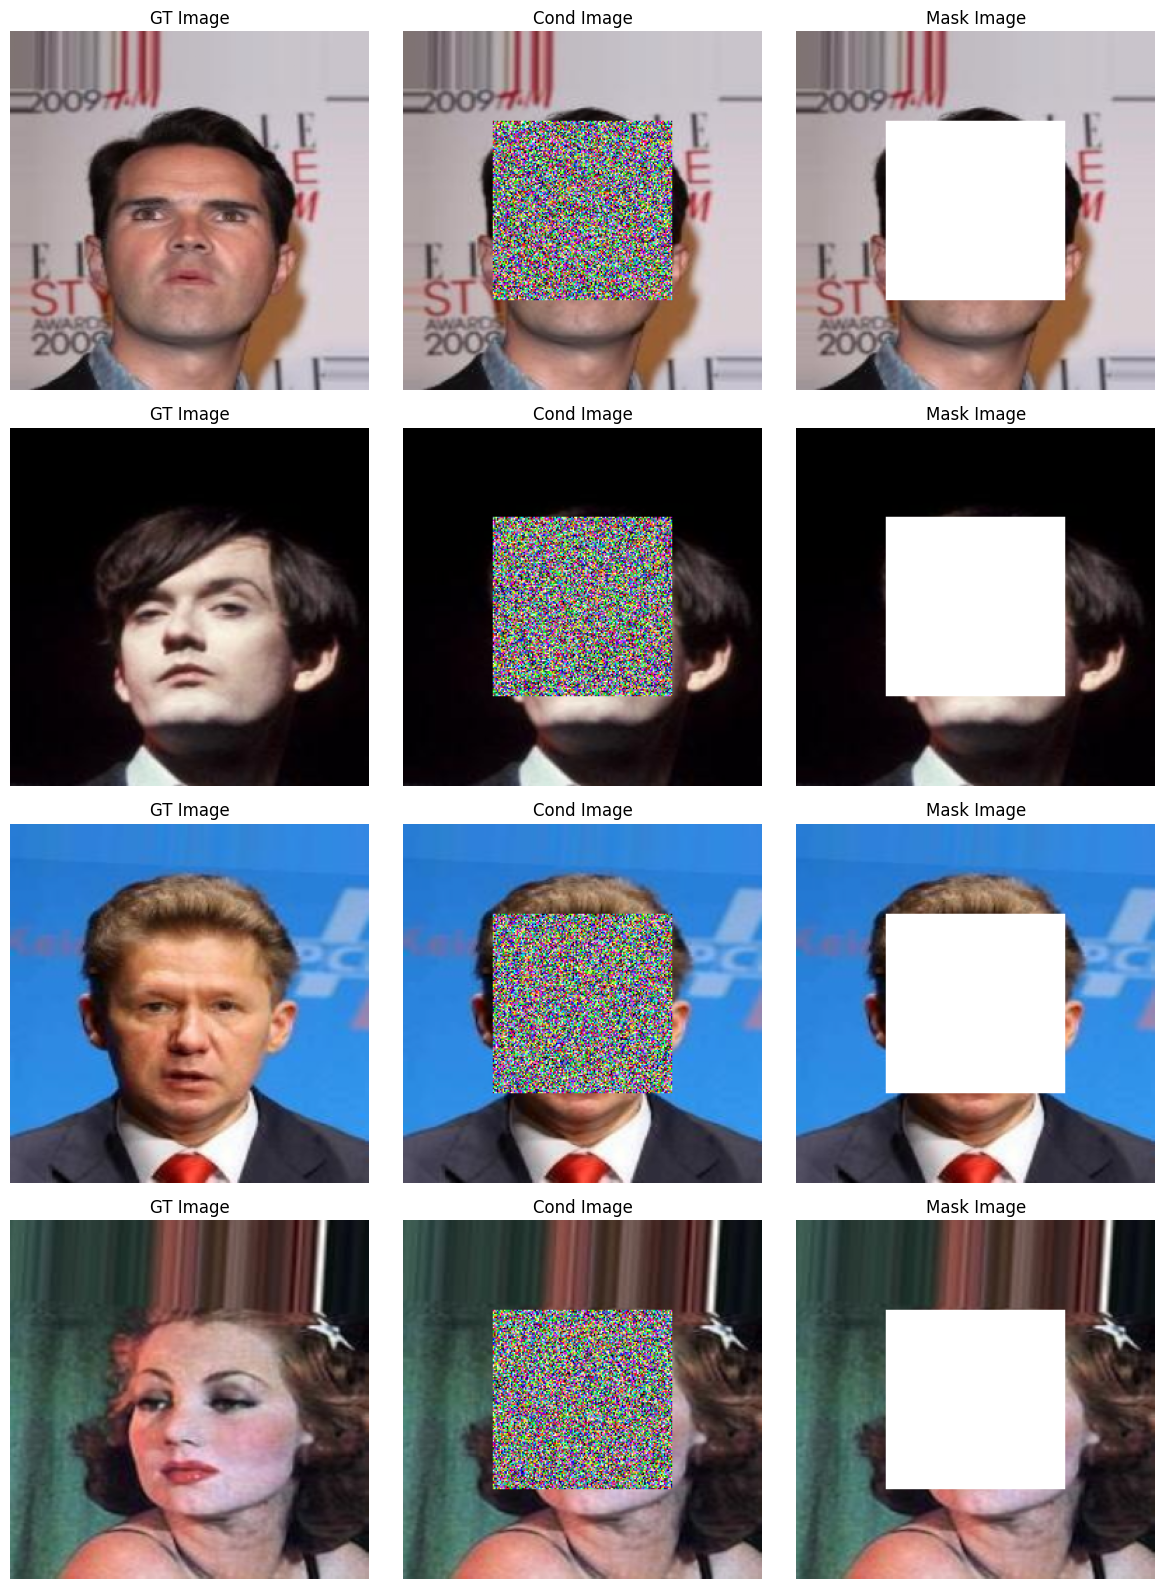

In [14]:
# Lấy batch
data_iter = iter(train_loader)
batch = next(data_iter)

# Gọi hàm hiển thị 3 loại ảnh
show_three_images(batch, num_samples=4)

## Model

In [ ]:
from torch import nn
import math
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, up = False):
        super(Block, self).__init__()
        self.time_emb_proj = nn.Linear(time_emb_dim, out_channels)
        if up:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1)
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
            self.transform = nn.Conv2d(
                out_channels, out_channels, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x, t):
        x = self.relu(self.bn1(self.conv1(x)))
        t = self.relu(self.time_emb_proj(t))
        t = t.unsqueeze(2).unsqueeze(2) # (B, C) -> (B, C, 1, 1)
        t = t.expand(-1, -1, x.shape[2], x.shape[3]) # (B, C, 1, 1) -> (B, C, H, W)
        x = x + t
        x = self.relu(self.bn2(self.conv3(x)))

        # up or downsampling
        x = self.transform(x)
        return x
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time_emb):
        device = time_emb.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(
            half_dim, device=device) * -embeddings)
        embeddings = torch.tensor(time_emb).unsqueeze(
            1) * embeddings.unsqueeze(0) # (B, 1) * (1, half_dim) -> (B, half_dim) : scalar * vector
        
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        
        return embeddings
    


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Time embedding
        t = self.time_mlp(timestep)

        # Initial projection
        x = self.conv0(x)

        # Downsample
        for down in self.downs:
            x = down(x, t)

        # Upsample
        for up in self.ups:
            x = up(x, t)

        # Output layer
        return self.output(x)
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model


Num params:  51297763


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_emb_proj): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): Block(
      (time_emb_proj): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))

In [ ]:
x = img_with_mask[0:1]  # Lấy một bức ảnh, shape (1, C, H, W)
x = x.to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Tạo bước thời gian (timestep) cho ảnh. Ví dụ, dùng giá trị 10.
timestep = torch.tensor([10.0], device=device)

with torch.no_grad():
    output = model(x, timestep)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20708\3196022626.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = torch.tensor(time_emb).unsqueeze(


Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])


### Forward Diffusion Process

In [ ]:
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def make_beta_schedule(schedule, n_timestep, linear_start=1e-5, linear_end=1e-2):
    if schedule == 'linear':
        betas = np.linspace(linear_start, linear_end,
                            n_timestep, dtype=np.float64)
    else:
        raise NotImplementedError(schedule)
    return betas

def get_index_from_list(vals, t, x_shape=(1, 1, 1, 1)):
    batch_size, *_ = t.shape
    out = vals.gather(-1, t)  # (4,)-> hàm gather sẽ lấy t ở mỗi sample trong batch
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(device) # (4,) -> (4, 1, 1, 1)


# Tạo mảng betas
test_betas = make_beta_schedule('linear', 1000, 1e-5, 1e-2)
vals = torch.from_numpy(test_betas).float().to(device)  # shape: (1000,)

# Tạo ví dụ batch_size=4, mỗi phần tử có 1 timestep ngẫu nhiên
batch_size = 4
t = torch.randint(0, 1000, (batch_size,), device=device)
x_shape = (4, 3, 64, 64)
out = get_index_from_list(vals, t, x_shape=x_shape)
print("vals shape: ", vals.shape)  # (1000,)
print("t shape: ", t.shape)        # (4,)
print("out shape:", out.shape)     # (4,1,1,1)

out shape: torch.Size([4])
vals shape:  torch.Size([1000])
t shape:  torch.Size([4])
out shape: torch.Size([4, 1, 1, 1])


In [ ]:
from tqdm import tqdm
from functools import partial

class InpaintingGaussianDiffusion(nn.Module):
    def __init__(self, unet_config, beta_schedule, **kwargs):
        super(InpaintingGaussianDiffusion, self).__init__(**kwargs)
        self.denoise_fn = SimpleUnet() 
        self.beta_schedule = beta_schedule

    def set_new_noise_schedule(self, device):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=device)
        betas = make_beta_schedule(**self.beta_schedule)
        alphas = 1. - betas
        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        gammas = np.cumprod(alphas, axis=0) # alphas_cumprod
        gammas_prev = np.append(1., gammas[:-1]) # gammas[:-1]: lấy tất cả các phần tử trừ phần tử cuối cùng, thêm 1 ở đầu: vì x0 không bị nhiễu

        # calculations for diffusion q(x_t | x_{t-1}) and others 
        self.register_buffer('gammas', to_torch(gammas))
        self.register_buffer('sqrt_recip_gammas', to_torch(np.sqrt(1. / gammas)))
        self.register_buffer('sqrt_recipm1_gammas', to_torch(np.sqrt(1. / gammas - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1. - gammas_prev) / (1. - gammas)
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(betas * np.sqrt(gammas_prev) / (1. - gammas)))
        self.register_buffer('posterior_mean_coef2', to_torch((1. - gammas_prev) * np.sqrt(alphas) / (1. - gammas)))

    def set_loss(self, loss_fn):
        self.loss_fn = loss_fn

    def predict_start_from_noise(self, y_t, t, noise):
        return (
            get_index_from_list(self.sqrt_recip_gammas, t, y_t.shape) * y_t -
            get_index_from_list(self.sqrt_recipm1_gammas, t, y_t.shape) * noise
        )

    def q_posterior(self, y_0_hat, y_t, t):
        """
        Compute the mean and variance of the diffusion posterior:

            q(x_{t-1} | x_t, x_0)

        """
        posterior_mean = (
            get_index_from_list(self.posterior_mean_coef1, t, y_t.shape) * y_0_hat +
            get_index_from_list(self.posterior_mean_coef2, t, y_t.shape) * y_t
        )
        posterior_log_variance_clipped = get_index_from_list(
            self.posterior_log_variance_clipped, t, y_t.shape
        )
        return posterior_mean, posterior_log_variance_clipped

    def p_mean_variance(self, y_t, t, clip_denoised: bool, y_cond=None):
        noise_level = get_index_from_list(self.gammas, t, x_shape=(1, 1)).to(y_t.device)
        y_0_hat = self.predict_start_from_noise(
                y_t, t=t, noise=self.denoise_fn(torch.cat([y_cond, y_t], dim=1), noise_level))

        if clip_denoised:
            y_0_hat.clamp_(-1., 1.)

        model_mean, posterior_log_variance = self.q_posterior(
            y_0_hat=y_0_hat, y_t=y_t, t=t)
        return model_mean, posterior_log_variance

    def q_sample(self, y_0, sample_gammas, noise=None):
        noise = noise if noise is not None else torch.randn_like(y_0)
        return (
            sample_gammas.sqrt() * y_0 +
            (1 - sample_gammas).sqrt() * noise
        )

    @torch.no_grad()
    def p_sample(self, y_t, t, clip_denoised=True, y_cond=None):
        model_mean, model_log_variance = self.p_mean_variance(
            y_t=y_t, t=t, clip_denoised=clip_denoised, y_cond=y_cond)
        noise = torch.randn_like(y_t) if any(t>0) else torch.zeros_like(y_t)
        return model_mean + noise * (0.5 * model_log_variance).exp()

    @torch.no_grad()
    def restoration(self, y_cond, y_t=None, y_0=None, mask=None, sample_num=8):
        b, *_ = y_cond.shape

        sample_inter = (self.num_timesteps//sample_num)

        y_t = y_t if y_t is not None else torch.randn_like(y_cond)
        ret_arr = y_t
        for i in reversed(range(0, self.num_timesteps)):
            t = torch.full((b,), i, device=y_cond.device, dtype=torch.long)
            y_t = self.p_sample(y_t, t, y_cond=y_cond)
            if mask is not None:
                y_t = y_0*(1.-mask) + mask*y_t # giữ nhiễu cho trung tâm + rìa ảnh là ảnh gốc
            if i % sample_inter == 0:
                ret_arr = torch.cat([ret_arr, y_t], dim=0)
        return y_t, ret_arr

    def forward(self, y_0, y_cond=None, mask=None, noise=None):
        """
        Sampling from p(gammas). 
        y_0: ảnh gốc hoặc dữ liệu gốc
        y_cond: điều kiện (có thể là ảnh mask, hoặc feature,...)
        mask: mask (nếu đang làm inpainting)
        noise: nhiễu đầu vào (nếu cần quy định rõ), nếu không sẽ tự sinh
        """
        # batch size b, còn *_ cho các chiều còn lại (C,H,W)
        b, *_ = y_0.shape

        # Lấy ra chỉ số thời gian t ngẫu nhiên trong [1, num_timesteps)
        t = torch.randint(1, self.num_timesteps, (b,), device=y_0.device).long()

        # Lấy gamma ở bước (t-1) và t
        gamma_t1 = get_index_from_list(self.gammas, t - 1, x_shape=(1, 1))
        gamma_t2 = get_index_from_list(self.gammas, t, x_shape=(1, 1))

        # Tạo sample_gammas bằng cách nội suy (hoặc random) giữa gamma_t1 và gamma_t2
        sample_gammas = torch.sqrt(gamma_t2 - gamma_t1) * torch.rand((b, 1), device=y_0.device) + gamma_t1
        sample_gammas = sample_gammas.view(b, 1, 1, 1)

        # Nếu chưa truyền noise thì tự sinh ngẫu nhiên
        noise = noise if noise is not None else torch.randn_like(y_0)

        # Tạo dữ liệu nhiễu y_noisy bằng hàm q_sample (thêm nhiễu vào y_0)
        y_noisy = self.q_sample(y_0=y_0, sample_gammas=sample_gammas, noise=noise)
        """
        y_noisy * (mask trung tâm giữ lại) + (1.-mask)*y_0 (giữ lại rìa ảnh) => rìa: ảnh gốc, mask: x_t
        y_cond = rìa: ảnh gốc, trung tâm: noise hoàn toàn
        """
        # Nếu có mask (trường hợp inpainting)
        if mask is not None:
            # Ghép y_cond với (y_noisy * mask + (1 - mask) * y_0)
            noise_hat = self.denoise_fn(
                torch.cat([y_cond, y_noisy * mask + (1. - mask) * y_0], dim=1),
                sample_gammas
            )
            # Tính loss với phần nhiễu được mask
            loss = self.loss_fn(mask * noise, mask * noise_hat)
        else:
            # Nếu không có mask, ghép y_cond với y_noisy trực tiếp
            noise_hat = self.denoise_fn(
                torch.cat([y_cond, y_noisy], dim=1),
                sample_gammas
            )
            # Tính loss trên toàn bộ noise
            loss = self.loss_fn(noise, noise_hat)

        return loss

## Trainning

In [ ]:
unet_config = {
    "in_channel": 6,
    "out_channel": 3,
    "inner_channel": 64,
    "channel_mults": [1, 2, 4, 8],
    "attn_res": [16],
    "num_head_channels": 32,
    "res_blocks": 2,
    "dropout": 0.2,
    "image_size": 256
}

beta_schedule = {
    "schedule": "linear",
    "n_timestep": 20,
    "linear_start": 1e-4,
    "linear_end": 0.09
}
inpainting_model = InpaintingGaussianDiffusion(unet_config, beta_schedule)

### Metric and Loss

In [ ]:
import torch.nn.functional as F

def mse_loss(output, target):
    return F.mse_loss(output, target)


def mae(input, target):
    with torch.no_grad():
        loss = nn.L1Loss()
        output = loss(input, target)
    return output

### Trainner

In [ ]:
import time

class Trainer():
    def __init__(self, model, optimizers, train_loader, val_loader, epochs, sample_num, device, save_model):
        self.model = model.to(device)
        self.optimizer = torch.optim.Adam(list(filter(
            lambda p: p.requires_grad, self.model.parameters()
        )), **optimizers)
        self.model.set_loss(mse_loss)
        self.model.set_new_noise_schedule(device)
        self.sample_num = sample_num
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.epochs = epochs
        self.save_model = save_model + "/best_model.pth"

    def train_step(self):
        self.model.train()
        losses = []
        for batch in tqdm(self.train_loader):
            gt_image = batch['gt_image'].to(self.device)
            cond_image = batch['cond_image'].to(self.device)
            mask = batch['mask'].to(self.device)
            mask_image = batch['mask_image'].to(self.device)
            batch_size = len(batch['path'])

            self.optimizer.zero_grad()

            loss = self.model(gt_image, cond_image, mask=mask)
            loss.backward()
            losses.append(loss.item())
            self.optimizer.step()
        return sum(losses) / len(losses)

    def val_step(self):
        self.model.eval()
        losses, metrics = [], []
        with torch.no_grad():
            for batch in tqdm(self.val_loader):
                gt_image = batch['gt_image'].to(self.device)
                cond_image = batch['cond_image'].to(self.device)
                mask = batch['mask'].to(self.device)
                mask_image = batch['mask_image'].to(self.device)
                loss = self.model(gt_image, cond_image, mask=mask)

                output, visuals = self.model.restoration(
                    cond_image, y_t=cond_image, y_0=gt_image, mask=mask, sample_num=self.sample_num)
                mae_score = mae(gt_image, output)

                losses.append(loss.item())
                metrics.append(mae_score.item())
        return sum(losses) / len(losses), sum(metrics) / len(metrics)

    def train(self):
        best_mae = 100000
        for epoch in range(self.epochs):
            epoch_start_time = time.time()
            train_loss = self.train_step()
            val_loss, val_mae = self.val_step()
            if val_mae < best_mae:
                torch.save(self.model.state_dict(), self.save_model)
            # Print loss, acc end epoch
            print("-" * 59)
            print(
                "| End of epoch {:3d} | Time: {:5.2f}s | Train Loss {:8.3f} "
                "| Valid Loss {:8.3f} | Valid MAE {:8.3f} ".format(
                    epoch + 1, time.time() - epoch_start_time, train_loss, val_loss, val_mae
                )
            )
            print("-" * 59)
        self.model.load_state_dict(torch.load(self.save_model))